### **Config**

In [37]:
import sys
sys.path.insert(0, '/home/marco/epfl/magma/')
import config

In [38]:
# General configurations

MODEL = 'pegasus'

RE_SPLITTER = '\n'              # do we split sentences of paragraphs? ('\.(?!\d)|\n')

# Output path
OUTPUT_PATH = config.MAGMA_DIR+'experiments/exploration_output/'

### **Init**

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
import gensim

if 'pegasus' in MODEL:
    from transformers import PegasusTokenizer
    tokenizer =\
        PegasusTokenizer.from_pretrained('google/pegasus-large')
elif 'bart' in MODEL:
    from transformers import BartTokenizer
    tokenizer =\
        BartTokenizer.from_pretrained('facebook/bart-large-cnn')
elif 't5' in MODEL:
    from transformers import T5Tokenizer
    tokenizer =\
        T5Tokenizer.from_pretrained('t5-large')

### **Karger Books Base Dataset**

In [40]:
base_dataset = config.MAGMA_DIR+'datasets/karger_books_base/df.csv'
df = pd.read_csv(base_dataset)
df = df.set_index(['book', 'chapter', 'section', 'subsection'])
df.bullets = df.bullets.map(eval, na_action='ignore')

In [41]:
print('Number of books we keep: %d'%len(set(df.index.get_level_values(0))))
print('Number of chapters: %d'%len(set(zip(df.index.get_level_values(0), df.index.get_level_values(1)))))

Number of books we keep: 53
Number of chapters: 496


## **Study of the data**

### **Preprocessing**

#### Preprocessing

* Split based on RE_SPLITTER
* Explode the dataset
* Remove unwanted chars at beginning or end of sentence
* Remove multiple spaces
* Remove long words (> config.TOKEN_MAX_LEN chars)
* Remove short sentences / paragraphs (< config.PARA_MIN_LEN tokens)

In [42]:
# Split in sentences / paragraphs based on RE_SPLITTER
df.text =\
    df.text.map(lambda x: [p.strip() for p in re.split(RE_SPLITTER, x) if p!=''],
                na_action='ignore')
    
# explode to get one row for each paragraph /sentence
df = df.explode('text')
df = df.rename(columns={'text': 'para'})
df = df.dropna()

# Remove unwanted chars at beginning or end of sentence
df.para = df.para.map(lambda p: p.lstrip('.,;:-)] \n'))
df.para = df.para.map(lambda p: p.rstrip('.,;:-([ \n'))

# Remove multiple spaces
df.para = df.para.map(lambda p:
    re.sub('\s+', ' ', p).strip())

# Remove long words (> config.TOKEN_MAX_LEN chars)
def para2words(para):
    return gensim.utils.simple_preprocess(
        para, deacc=True, max_len=config.TOKEN_MAX_LEN)
df['para_proc'] = df.para.map(para2words)

# Remove short sentences / paragraphs (< config.PARA_MIN_LEN tokens)
df.loc[df.para_proc.map(len) <\
    config.PARA_MIN_LEN, 'para_proc'] = np.nan

df = df.dropna()

In [45]:
df

para  \
book          chapter section subsection                                                      
9781905832729 ch_2    ch_2    ch_2               Anatomy and function of the urinary system   
                      1.i     1.i         A complete description of the anatomy of the u...   
                              1.i         The term 'internal sphincter' is often used an...   
                      1.ii    1.ii        Continence is maintained by a complex interact...   
                              1.ii        During normal voiding, voluntary relaxation of...   
...                                                                                     ...   
9783318068207 hh-8    sec29   sec29       Costs. Malapelle et al., in a validation study...   
                              sec29       In another study, Malapelle et al. reported th...   
                              sec29       Reimbursement. Besides the different gene pane...   
                              sec29       If there is a well-resourced reimbursement-bas...   
                              sec29       If there is universal healthcare, resources ar...   

                                                                                    bullets  \
book          chapter section subsection                                                      
9781905832729 ch_2    ch_2    ch_2        [The bladder operates as a low-pressure high-v...   
                      1.i     1.i         [The bladder operates as a low-pressure high-v...   
                              1.i         [The bladder operates as a low-pressure high-v...   
                      1.ii    1.ii        [The bladder operates as a low-pressure high-v...   
                              1.ii        [The bladder operates as a low-pressure high-v...   
...                                                                                     ...   
9783318068207 hh-8    sec29   sec29       [Different sample types (histological or cytol...   
                              sec29       [Different sample types (histological or cytol...   
                              sec29       [Different sample types (histological or cytol...   
                              sec29       [Different sample types (histological or cytol...   
                              sec29       [Different sample types (histological or cytol...   

                                                                                  para_proc  
book          chapter section subsection                                                     
9781905832729 ch_2    ch_2    ch_2        [anatomy, and, function, of, the, urinary, sys...  
                      1.i     1.i         [complete, description, of, the, anatomy, of, ...  
                              1.i         [the, term, internal, sphincter, is, often, us...  
                      1.ii    1.ii        [continence, is, maintained, by, complex, inte...  
                              1.ii        [during, normal, voiding, voluntary, relaxatio...  
...                                                                                     ...  
9783318068207 hh-8    sec29   sec29       [costs, malapelle, et, al, in, validation, stu...  
                              sec29       [in, another, study, malapelle, et, al, report...  
                              sec29       [reimbursement, besides, the, different, gene,...  
                              sec29       [if, there, is, well, resourced, reimbursement...  
                              sec29       [if, there, is, universal, healthcare, resourc...  

[18822 rows x 3 columns]

In [51]:
df.groupby(level=[0, 1], sort=False).count().groupby(level=[0], sort=False).count().sum()

para         453
bullets      453
para_proc    453
dtype: int64

### **Bullets distribution**

In [44]:
df.groupby(level=[0, 1], sort=False).agg({
    'bullets': lambda b: list(b)[0]
}).bullets.map(len).describe()

count    453.000000
mean       5.642384
std        2.001142
min        2.000000
25%        4.000000
50%        5.000000
75%        7.000000
max       16.000000
Name: bullets, dtype: float64

In [52]:
bullets_list = df.explode('bullets')['bullets'].unique()
bullets_list_ntok = [len(tokenizer.tokenize(b)) for b in bullets_list]
print('Number of bullet points:', len(bullets_list))

Number of bullet points: 2556


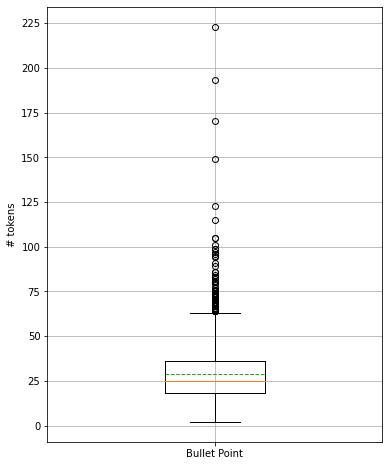

In [57]:
fig, ax = plt.subplots(figsize=(6, 8))

plt.boxplot(
    bullets_list_ntok,
    widths=0.3,
    patch_artist=False,
    meanline=True,
    showmeans=True)
ax.grid(True)
ax.set_ylabel('# tokens')
ax.set_xticklabels(['Bullet Point'])
plt.yticks(range(0, 230, 25))
plt.savefig(OUTPUT_PATH+'bullet_point_numtokens.png')
plt.show()

In [58]:
print('Number of tokens per one bullet, median:', np.median(bullets_list_ntok))

Number of tokens per one bullet, median: 25.0


In [59]:
df['bullets_tokenized'] = df.dropna().bullets.map(lambda x: [tokenizer.tokenize(b) for b in x])
df['bullets_num_tokens'] = df.dropna().bullets_tokenized.map(lambda x: np.sum([len(b) for b in x]))

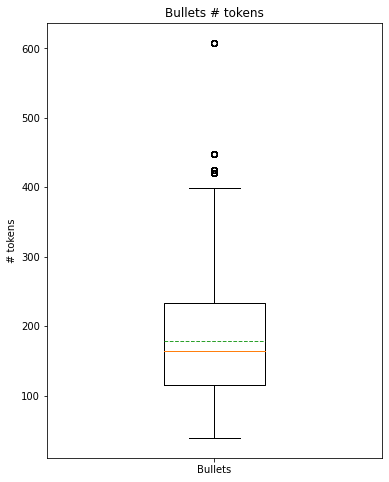

In [60]:
fig, ax = plt.subplots(figsize=(6, 8))

plt.boxplot(
    df.bullets_num_tokens.tolist(),
    widths=0.3,
    patch_artist=False,
    meanline=True,
    showmeans=True)

ax.set_title('Bullets # tokens')
ax.set_ylabel('# tokens')
ax.set_xticklabels(['Bullets'])
plt.savefig(OUTPUT_PATH+'bullets_numtokens.png')
plt.show()

In [61]:
print('Number of tokens per bullet points, median:', np.median(df.bullets_num_tokens.tolist()))

Number of tokens per bullet points, median: 164.0


Let's study the outliers

In [62]:
df_explore_outliers = df[['bullets', 'bullets_num_tokens']].copy()
df_explore_outliers.bullets = df_explore_outliers.bullets.map(lambda b: ' '.join(b))
df_explore_outliers = df_explore_outliers.drop_duplicates()
df_explore_outliers = df_explore_outliers[df_explore_outliers['bullets_num_tokens'] > 400]
for idx, b in df_explore_outliers.sort_values('bullets_num_tokens', ascending=False).bullets.iteritems():
    print(idx)
    print(b)
    print()

(9781908541727, 'ch10', 'ch10', 'ch10')
Refer urgently, to be seen the same day, if your patient is:- a neonate with red eyes and eye watering or discharge (possible ophthalmia neonatorum)- a neonate or child with an abnormal red reflex (possible retinoblastoma or congenital cataract)- an infant or child with photophobia, constant tearing (epiphora), corneal enlargement or cloudy cornea (possible congenital glaucoma)- a child with red eye with pain, photophobia or blurred vision (possible corneal ulcer, iritis or endophthalmitis)- an older child with double vision (causes include brain tumor or aneurysm)- a child of any age with swollen optic disc/s on ophthalmoscopy (possible brain tumor or hydrocephalus).- an infant or child with preseptal or orbital cellulitis- an infant or child with ptosis- an infant or child with a history of eye trauma or possible shaken baby syndrome. Refer within 1 week, any child with:- squint ('turned eye', strabismus) or nystagmus (constantly moving eyes) n

### **Chapters distribution**

In [69]:
df.groupby(level=[0, 1], sort=False).agg({
    'para': lambda p: ' '.join(p+'.')
}).para.map(tokenizer.tokenize).map(len).describe()

count      453.000000
mean      2717.490066
std       1745.593861
min        586.000000
25%       1539.000000
50%       2287.000000
75%       3338.000000
max      12507.000000
Name: para, dtype: float64

### **Paragraphs distribution**

In [70]:
print('Number of paragraphs:', len(df))

Number of paragraphs: 18822


In [71]:
df['para_tokenized'] = df.para.map(tokenizer.tokenize)
df['para_num_tokens'] = df.para_tokenized.str.len()

df['bullets_tokenized'] = df.dropna().bullets.map(lambda x: [tokenizer.tokenize(b) for b in x])
df['bullets_num_tokens'] = df.dropna().bullets_tokenized.map(lambda x: np.sum([len(b) for b in x]))

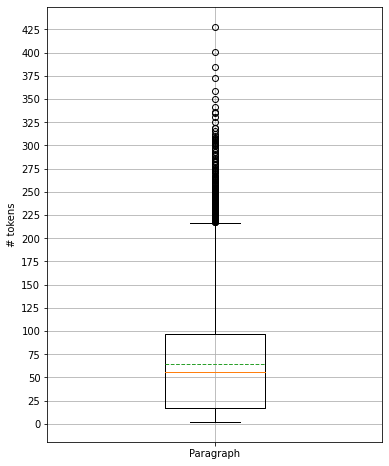

In [73]:
fig, ax = plt.subplots(figsize=(6, 8))

plt.boxplot(
    df.para_num_tokens.tolist(),
    widths=0.3,
    patch_artist=False,
    meanline=True,
    showmeans=True)
ax.grid(True)
ax.set_ylabel('# tokens')
ax.set_xticklabels(['Paragraph'])
plt.yticks(range(0, 430, 25))
plt.savefig(OUTPUT_PATH+'para_numtokens.png')
plt.show()

Let's study the outliers

In [19]:
df_explore_outliers = df[['para', 'para_num_tokens']].copy()
df_explore_outliers = df_explore_outliers[df_explore_outliers['para_num_tokens'] > 350]
for idx, p in df_explore_outliers.sort_values('para_num_tokens', ascending=False).para.iteritems():
    print(idx)
    print(p)
    print()

(9781910797693, 'chp4', 'sect13', 'sect13')
Epoetin. In Thailand, more than a dozen different copies of epoetin-alfa were marketed but had not been approved through stringent regulatory procedures such as in the EU and USA. Simple analytics such as isoelectric gel chromatography showed that many of these copies were structurally different from the reference drug (epoetin-alfa Epogen ®). Twelve such intended copy biologics were analyzed in a joint Thai-Dutch study. Some showed high aggregate levels and contained substantial levels of protein fragments - a critical attribute of these medicines that has been strongly associated with a rare but potentially fatal adverse drug reaction., Epoetin aggregates can promote the development of anti-drug immune reactions which can neutralize both the medicine and the erythropoietin produced by the kidneys, causing pure red cell aplasia (PRCA). Affected patients become profoundly anemic and transfusion dependent, and will die if the auto-immunity can

### **Sections distribution**

In [20]:
df = df.groupby(level=[0,1,2,3], sort=False).agg(
    {'para': lambda t: ''.join([p+'. ' for p in t]).strip(),
     'bullets': lambda b: list(b)[0]})
df = df.rename(columns={'para': 'text'})

In [21]:
print('Number of sections:', len(df))

Number of sections: 2730


In [22]:
df['text_tokenized'] = df.text.map(tokenizer.tokenize)
df['text_num_tokens'] = df.text_tokenized.str.len()

df['bullets_tokenized'] = df.bullets.map(lambda x: [tokenizer.tokenize(b) for b in x])
df['bullets_num_tokens'] = df.bullets_tokenized.map(lambda x: np.sum([len(b) for b in x]))

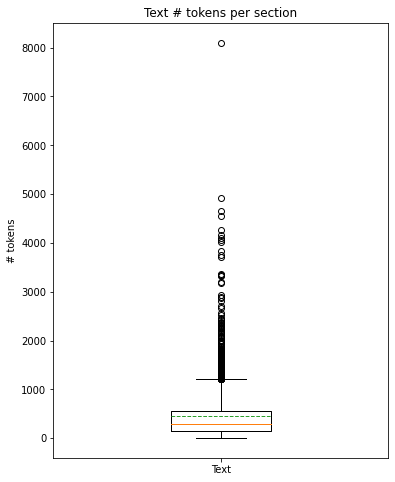

In [23]:
fig, ax = plt.subplots(figsize=(6, 8))

plt.boxplot(
    df.text_num_tokens.tolist(),
    widths=0.3,
    patch_artist=False,
    meanline=True,
    showmeans=True)
ax.grid(False)
ax.set_title('Text # tokens per section')
ax.set_ylabel('# tokens')
ax.set_xticklabels(['Text'])
plt.savefig(OUTPUT_PATH+'sec_text_numtokens.png')
plt.show()

Most of the sections have a low number of tokens, with a median of around 250. However, there is a consistent number of outliers with more than 1'000 tokens or less than 50.

This is a problem because the first cannot fit entirely into the model and the latter cannot be used alone to produce a summary.

In [24]:
df[['text_num_tokens', 'bullets_num_tokens']].sort_values(by='text_num_tokens', ascending=False)

text_num_tokens  bullets_num_tokens
book          chapter section subsection                                     
9781908541277 ch_8    sec1    sec1                   8102                  67
9781908541178 ch_6    3.iii   3.iii                  4925                 191
9781908541406 ch_15   sec1    sec1                   4655                 192
9781908541680 ch_9    sec1    sec1                   4555                 127
9781910797471 ch03    sect10  sect10                 4255                 190
...                                                   ...                 ...
9781910797426 ch08    ch08    ch08                      3                 155
              ch09    ch09    ch09                      3                  64
9781908541680 ch_5    ch_5    ch_5                      3                 124
9781908541277 ch_11   ch_11   ch_11                     3                 358
9781912776238 ch4     ch4     ch4                       3                  76

[2730 rows x 2 columns]

Is the number of sections in a chapter correlated with the # tokens per section in that chapter?

In [25]:
df_corr = df.groupby(level=[0, 1]).agg(
    {'text': lambda t: len(list(t)),
     'text_num_tokens': lambda tnm: np.median(list(tnm))})
df_corr = df_corr.rename(columns={'text': 'num_sections'})

In [26]:
df_corr.corr('pearson')

,num_sections,text_num_tokens
num_sections,1.000000,-0.273959
text_num_tokens,-0.273959,1.000000


The answer is yes, we have a negative correlation between the number of sections in a chapter and the number of tokens per section. This means the more sections we have in a chapter, the shorter these sections will be and viceversa.

### **Text vs Bullets length**

In [27]:
df = df.groupby(level=[0, 1]).agg(
    {'text': lambda t: ' '.join(list(t)),
     'bullets': lambda b: list(b)[0]})

In [28]:
df['text_tokenized'] = df.text.map(tokenizer.tokenize)
df['text_num_tokens'] = df.text_tokenized.str.len()

df['bullets_tokenized'] = df.dropna().bullets.map(lambda x: [tokenizer.tokenize(b) for b in x])
df['bullets_num_tokens'] = df.dropna().bullets_tokenized.map(lambda x: np.sum([len(b) for b in x]))

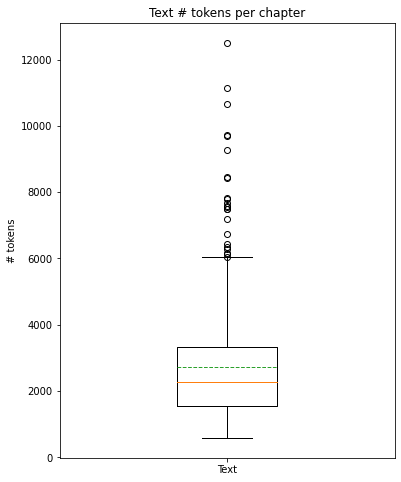

In [29]:
fig, ax = plt.subplots(figsize=(6, 8))

plt.boxplot(
    df.text_num_tokens.tolist(),
    widths=0.3,
    patch_artist=False,
    meanline=True,
    showmeans=True)
ax.grid(False)
ax.set_title('Text # tokens per chapter')
ax.set_ylabel('# tokens')
ax.set_xticklabels(['Text'])
plt.savefig(OUTPUT_PATH+'chp_text_numtokens.png')
plt.show()

Taking chapters into consideration, we can see that the number of tokens per chapter is around 3000 on average. The distribution is a bit skewed.

Since we aim to a summary of around 180 tokens, we want to keep only around **6% of the original text**.

In [30]:
df[['text_num_tokens', 'bullets_num_tokens']].sort_values(
    by='bullets_num_tokens', ascending=False)

,,text_num_tokens,bullets_num_tokens
book,chapter,,
9781908541727,ch10,1531,608
9781910797617,chp3,6127,448
9781908541727,ch11,2462,425
9783318068207,hh-7,5874,420
9781910797495,chp7,2599,399
...,...,...,...
9781910797587,chp09,1660,45
9781910797105,ch01,977,44
9781912776153,chp6,3696,43


/home/marco/miniconda3/envs/magma/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


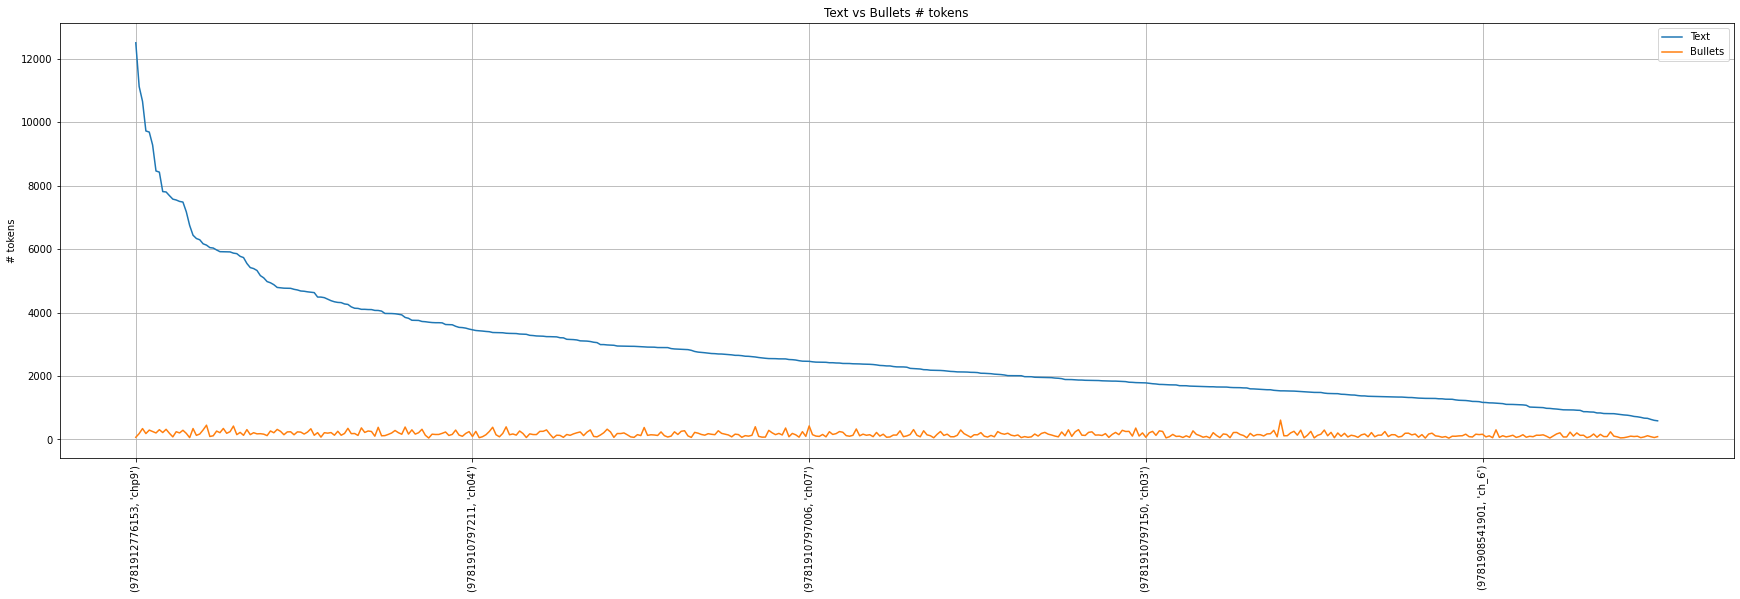

In [31]:
df_comp = df[['text_num_tokens', 'bullets_num_tokens']]\
    .sort_values(by='text_num_tokens', ascending=False)

fig, ax = plt.subplots(figsize=(30, 8))

rects1 = ax.plot(
    df_comp.text_num_tokens.tolist(),
    label='Text')
rects2 = ax.plot(
    df_comp.bullets_num_tokens.tolist(),
    label='Bullets')

ax.set_title('Text vs Bullets # tokens')
ax.set_ylabel('# tokens')
ax.grid()
xticks = list(zip(df_comp.index.get_level_values(0), df_comp.index.get_level_values(1)))
ax.set_xticklabels(xticks, rotation=90)
ax.legend()
plt.savefig(OUTPUT_PATH+'chapter_vs_bullets_numtokens.png')
plt.show()

There is **not** a correlation between length of the chapter and length of the bullet points. Thus, we decide to set a fixed size for the summary (e.g. 180). Another approach would be to say we want to keep 6% of the starting text. Let's explore the two approaches in more details.

### **Variable vs fixed sized summary**

/home/marco/miniconda3/envs/magma/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


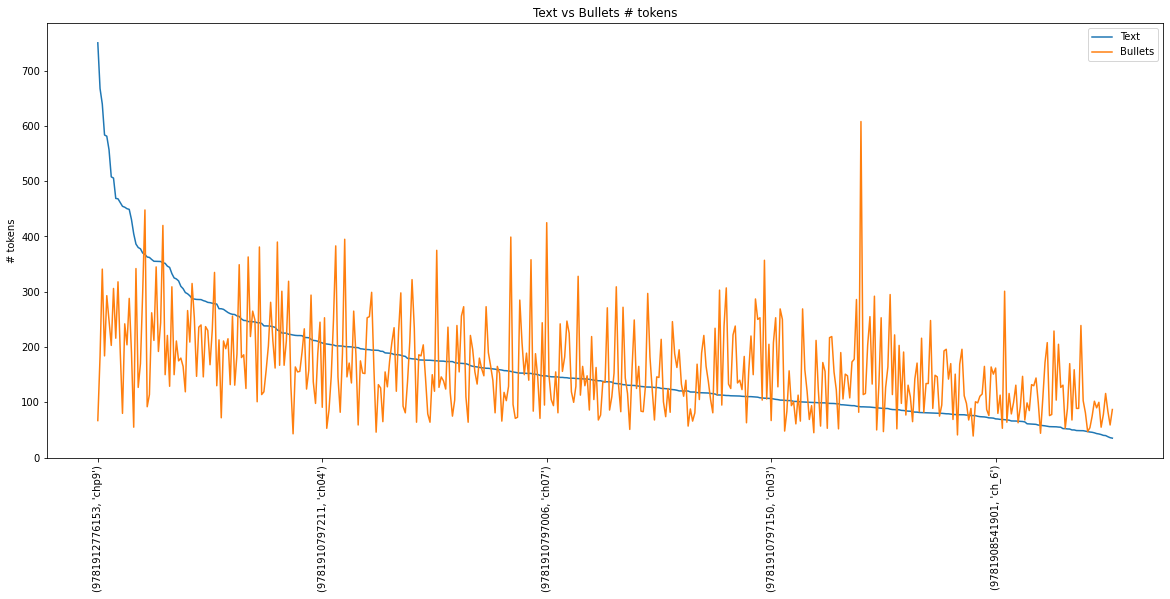

In [32]:
fig, ax = plt.subplots(figsize=(20, 8))

rects1 = ax.plot(
    (df_comp.text_num_tokens*0.06).tolist(),
    label='Text')
rects2 = ax.plot(
    df_comp.bullets_num_tokens.tolist(),
    label='Bullets')

ax.set_title('Text vs Bullets # tokens')
ax.set_ylabel('# tokens')
xticks = list(zip(df_comp.index.get_level_values(0), df_comp.index.get_level_values(1)))
ax.set_xticklabels(xticks, rotation=90)
ax.legend()
plt.savefig(OUTPUT_PATH+'06text_summary_vs_bullets.png')
plt.show()

In [33]:
print('Mean Absolute Error:\n')
np.sum(np.abs((df_comp.text_num_tokens*0.06)-df_comp.bullets_num_tokens)) / len(df_comp)

Mean Absolute Error:



77.50388520971302

Deciding the length of the chapter summary based on the length of the summary (e.g. 6% of the text number of tokens) results in very big discrepancies between the reference summary and the generated one.

This can be seen in the plot above, where for book 1 chapter 5 and book 2 chapter 6 we have a huge difference between generated and reference summary.

The result is a MAE of around 84 tokens.

/home/marco/miniconda3/envs/magma/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


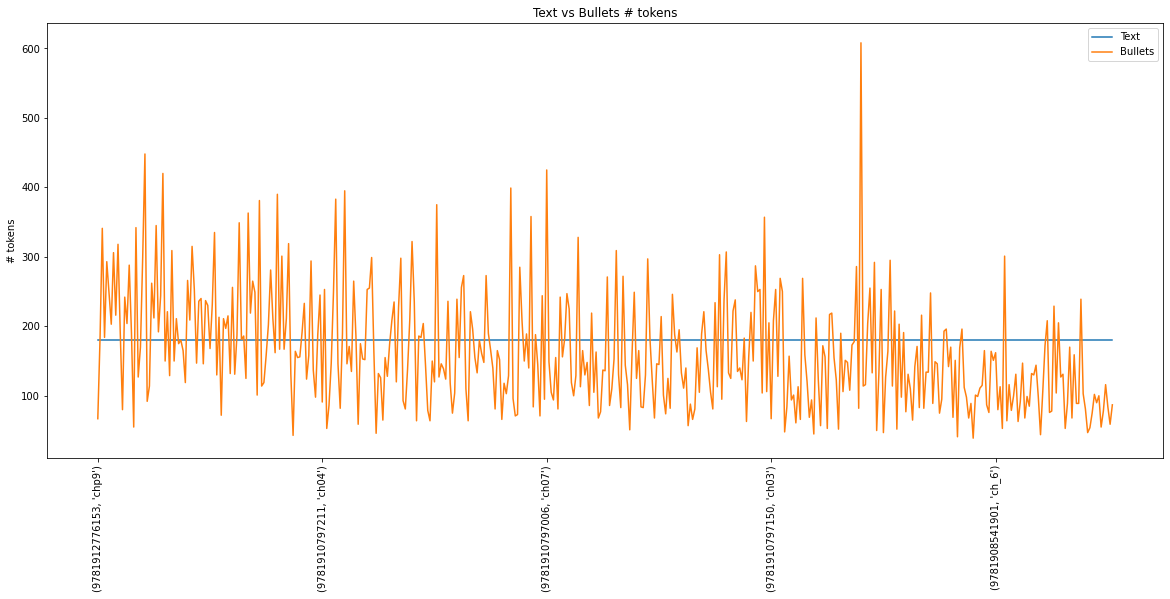

In [34]:
fig, ax = plt.subplots(figsize=(20, 8))

rects1 = ax.plot(
    [180]*len(df),
    label='Text')
rects2 = ax.plot(
    df_comp.bullets_num_tokens.tolist(),
    label='Bullets')

ax.set_title('Text vs Bullets # tokens')
ax.set_ylabel('# tokens')
xticks = list(zip(df_comp.index.get_level_values(0), df_comp.index.get_level_values(1)))
ax.set_xticklabels(xticks, rotation=90)
ax.legend()
plt.savefig(OUTPUT_PATH+'180_summary_vs_bullets.png')
plt.show()

In [35]:
print('Mean Absolute Error:\n')
np.sum(np.abs(180-df_comp.bullets_num_tokens)) / len(df_comp)

Mean Absolute Error:



68.68432671081678

On the other hand, deciding to produce reference summaries with a fixed length produce a much lower MAE of 70.